
# Michigan QCEW (Core-Auto, Lightcast Share) — Forecast Comparison (Moody vs BLS)

This notebook overlays **Moody** and **BLS** forecast extensions on top of the **Michigan QCEW core-auto adjusted baseline** (using Lightcast `share_to_set`), with the forecast window shaded.

**Inputs (from your pipeline):**
- Adjusted baselines (levels, core-auto):
  - `data/interim/mi_qcew_segment_employment_timeseries_coreauto.csv`
  - `data/interim/mi_qcew_stage_employment_timeseries_coreauto.csv`
- Extended & stacked comparison (levels + forecasts):
  - `data/processed/mi_qcew_segment_employment_timeseries_coreauto_extended_compare.csv`
  - `data/processed/mi_qcew_stage_employment_timeseries_coreauto_extended_compare.csv`


In [16]:

from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def find_repo_root(markers=("data", "scripts")) -> Path:
    here = Path.cwd()
    for p in (here, *here.parents):
        if all((p / m).exists() for m in markers):
            return p
    return here

REPO_ROOT = find_repo_root()
os.chdir(REPO_ROOT)
print("Working dir ->", Path.cwd())

DATA_INTERIM   = REPO_ROOT / "data" / "interim"
DATA_PROCESSED = REPO_ROOT / "data" / "processed"
FIG_DIR        = REPO_ROOT / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

SEG_BASE = DATA_INTERIM   / "mi_qcew_segment_employment_timeseries_coreauto.csv"
STG_BASE = DATA_INTERIM   / "mi_qcew_stage_employment_timeseries_coreauto.csv"
SEG_CMP  = DATA_PROCESSED / "mi_qcew_segment_employment_timeseries_coreauto_extended_compare.csv"
STG_CMP  = DATA_PROCESSED / "mi_qcew_stage_employment_timeseries_coreauto_extended_compare.csv"

for p in (SEG_BASE, STG_BASE, SEG_CMP, STG_CMP):
    if not p.exists():
        raise FileNotFoundError(f"Missing input: {p}. Run scripts/apply_lightcast_share_and_extend.py first.")


Working dir -> c:\Users\vasilauskas\GitHub\EV-Transition


In [17]:

seg_base = pd.read_csv(SEG_BASE)
stg_base = pd.read_csv(STG_BASE)
seg_cmp  = pd.read_csv(SEG_CMP)
stg_cmp  = pd.read_csv(STG_CMP)

for df in (seg_base, stg_base, seg_cmp, stg_cmp):
    if "year" in df.columns:
        df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
    if "employment_qcew" in df.columns:
        df["employment_qcew"] = pd.to_numeric(df["employment_qcew"], errors="coerce")

if "segment_name" not in seg_base.columns and "segment_label" in seg_base.columns:
    seg_base = seg_base.rename(columns={"segment_label": "segment_name"})
if "segment_name" not in seg_cmp.columns and "segment_label" in seg_cmp.columns:
    seg_cmp = seg_cmp.rename(columns={"segment_label": "segment_name"})

YR_MIN, YR_MAX = 2001, 2034
for df in (seg_base, stg_base, seg_cmp, stg_cmp):
    if "year" in df.columns:
        df.dropna(subset=["year"], inplace=True)
        df["year"] = df["year"].astype(int)
        df.query("@YR_MIN <= year <= @YR_MAX", inplace=True)

stage_order = ["Upstream", "OEM", "Downstream"]
if "stage" in stg_base.columns:
    stg_base["stage"] = pd.Categorical(stg_base["stage"], categories=stage_order, ordered=True)
if "stage" in stg_cmp.columns:
    stg_cmp["stage"] = pd.Categorical(stg_cmp["stage"], categories=stage_order, ordered=True)

print("Shapes:")
print(" seg_base:", seg_base.shape, "years:", seg_base["year"].min(), "–", seg_base["year"].max())
print(" stg_base:", stg_base.shape, "years:", stg_base["year"].min(), "–", stg_base["year"].max())
print(" seg_cmp :", seg_cmp.shape,  "years:", seg_cmp["year"].min(),  "–", seg_cmp["year"].max())
print(" stg_cmp :", stg_cmp.shape,  "years:", stg_cmp["year"].min(),  "–", stg_cmp["year"].max())


Shapes:
 seg_base: (240, 4) years: 2001 – 2024
 stg_base: (72, 3) years: 2001 – 2024
 seg_cmp : (440, 7) years: 2001 – 2034
 stg_cmp : (132, 6) years: 2001 – 2034


In [18]:

def _forecast_start_year(df):
    s = df.loc[df.get("value_type", pd.Series()).astype(str).eq("Forecast"), "year"]
    return int(s.min()) if not s.empty else None

def plot_stage_compare(stage_name: str):
    base = stg_base[stg_base["stage"].astype(str).eq(stage_name)].sort_values("year")
    cmp_  = stg_cmp[stg_cmp["stage"].astype(str).eq(stage_name)].sort_values("year")
    if base.empty and cmp_.empty:
        print(f"[skip] No data for stage {stage_name}")
        return

    fig, ax = plt.subplots(figsize=(12,6))
    if not base.empty:
        ax.plot(base["year"], base["employment_qcew"], label="QCEW (historical)", linestyle="-", linewidth=2)

    for src, ls in [("Moody", "--"), ("BLS", ":")]:
        f = cmp_[(cmp_["value_type"].astype(str).eq("Forecast")) & (cmp_["forecast_source"].astype(str).eq(src))]
        if not f.empty:
            ax.plot(f["year"], f["employment_qcew"], label=f"{src} forecast", linestyle=ls, linewidth=2)

    fstart = _forecast_start_year(cmp_)
    if fstart is not None and fstart <= YR_MAX:
        ax.axvspan(max(fstart, YR_MIN), YR_MAX, alpha=0.12, zorder=0)
        patch = Patch(alpha=0.12, label="Forecast window")
        handles, labels = ax.get_legend_handles_labels()
        handles.append(patch); labels.append("Forecast window")
        ax.legend(handles, labels, bbox_to_anchor=(1.02, 1), loc="upper left")
    else:
        ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")

    ax.set_xlim(YR_MIN, YR_MAX)
    ax.set_xlabel("Year")
    ax.set_ylabel("Employment (QCEW, core-auto)")
    ax.set_title(f"Michigan QCEW (Core-Auto) — {stage_name} (2001–2034)")
    fig.tight_layout()
    out = FIG_DIR / f"mi_qcew_coreauto_stage_{stage_name.lower()}_compare_2001_2034.png"
    fig.savefig(out, dpi=300, bbox_inches="tight")
    print(f"Saved: {out}")
    plt.show()
    plt.close(fig)

def plot_segment_compare(seg_id: int, seg_label: str):
    base = seg_base[seg_base["segment_id"].eq(seg_id)].sort_values("year")
    cmp_  = seg_cmp[seg_cmp["segment_id"].eq(seg_id)].sort_values("year")
    if base.empty and cmp_.empty:
        print(f"[skip] No data for segment {seg_id}")
        return

    fig, ax = plt.subplots(figsize=(14,8))
    if not base.empty:
        ax.plot(base["year"], base["employment_qcew"], label="QCEW (historical)", linestyle="-", linewidth=2)

    for src, ls in [("Moody", "--"), ("BLS", ":")]:
        f = cmp_[(cmp_["value_type"].astype(str).eq("Forecast")) & (cmp_["forecast_source"].astype(str).eq(src))]
        if not f.empty:
            ax.plot(f["year"], f["employment_qcew"], label=f"{src} forecast", linestyle=ls, linewidth=2)

    fstart = _forecast_start_year(cmp_)
    if fstart is not None and fstart <= YR_MAX:
        ax.axvspan(max(fstart, YR_MIN), YR_MAX, alpha=0.12, zorder=0)
        patch = Patch(alpha=0.12, label="Forecast window")
        handles, labels = ax.get_legend_handles_labels()
        handles.append(patch); labels.append("Forecast window")
        ax.legend(handles, labels, bbox_to_anchor=(1.02, 1), loc="upper left")
    else:
        ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")

    ax.set_xlim(YR_MIN, YR_MAX)
    ax.set_xlabel("Year")
    ax.set_ylabel("Employment (QCEW, core-auto)")
    ax.set_title(f"Michigan QCEW (Core-Auto) — {seg_label} (2001–2034)")
    fig.tight_layout()
    out = FIG_DIR / f"mi_qcew_coreauto_segment_{seg_id}_compare_2001_2034.png"
    fig.savefig(out, dpi=300, bbox_inches="tight")
    print(f"Saved: {out}")
    plt.show()
    plt.close(fig)


## Stage Comparison Plots

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_coreauto_stage_upstream_compare_2001_2034.png


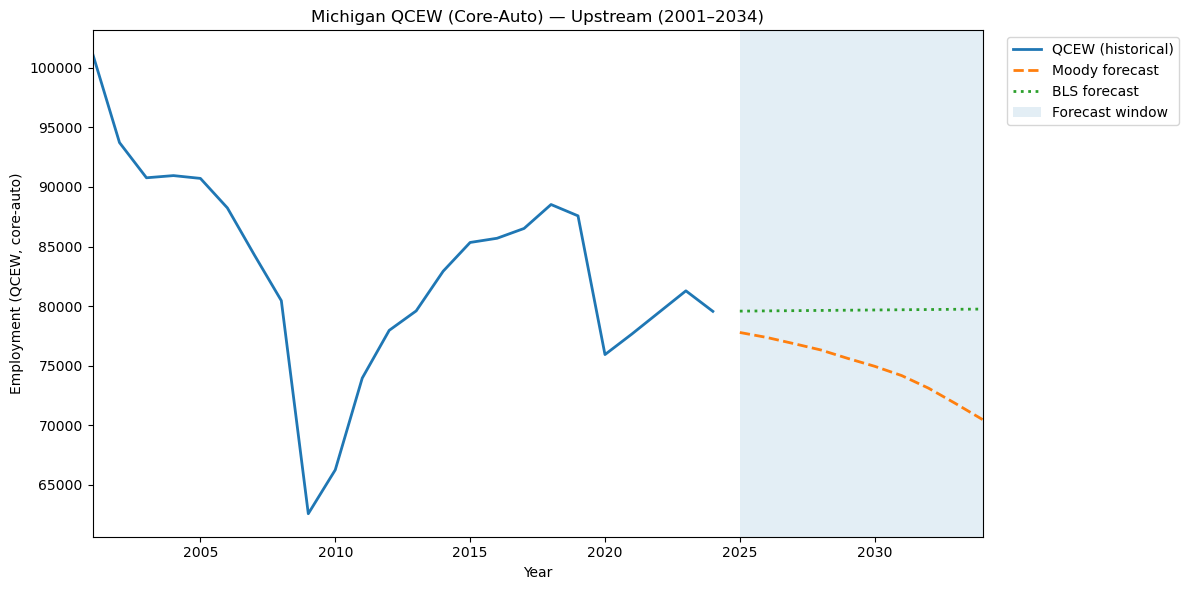

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_coreauto_stage_oem_compare_2001_2034.png


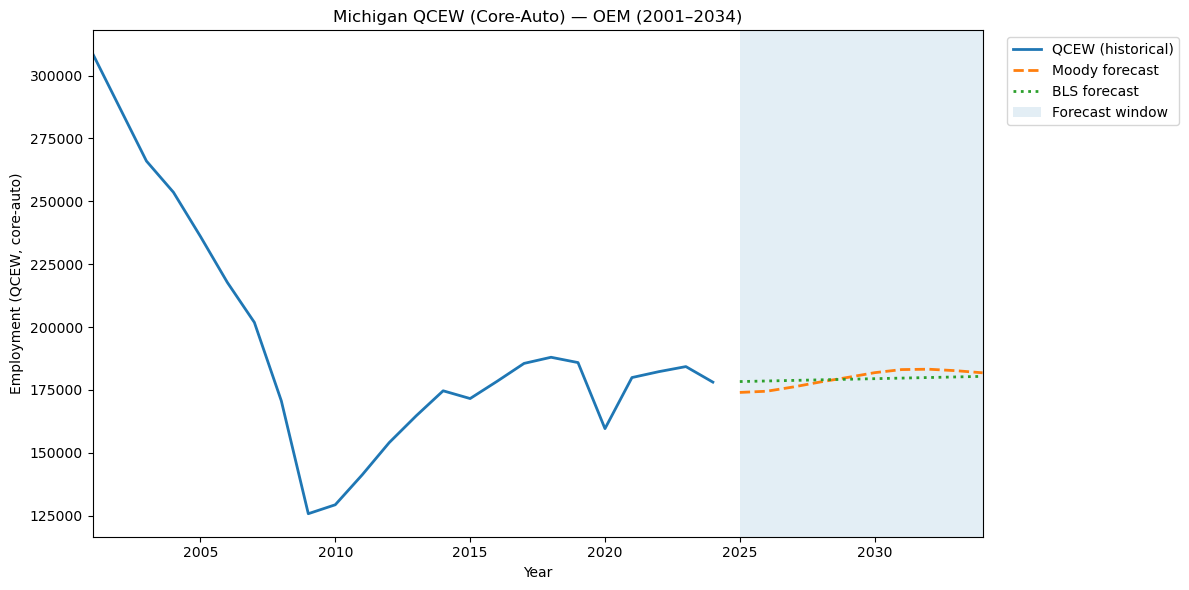

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_coreauto_stage_downstream_compare_2001_2034.png


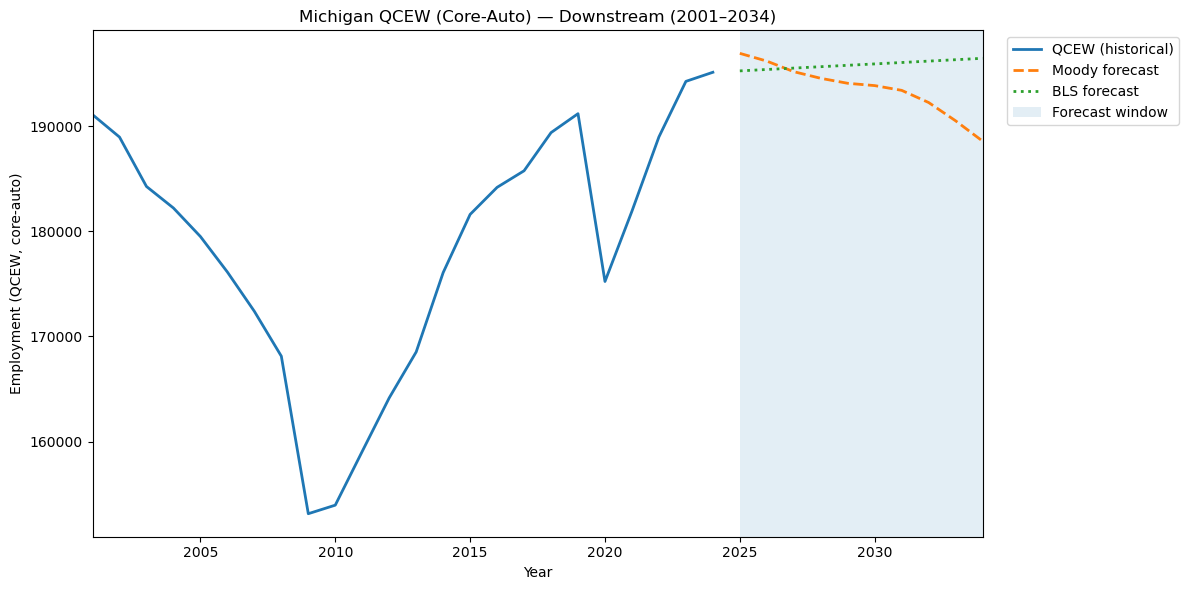

In [19]:

for st in ["Upstream", "OEM", "Downstream"]:
    plot_stage_compare(st)


## Segment Comparison Plots

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_coreauto_segment_1_compare_2001_2034.png


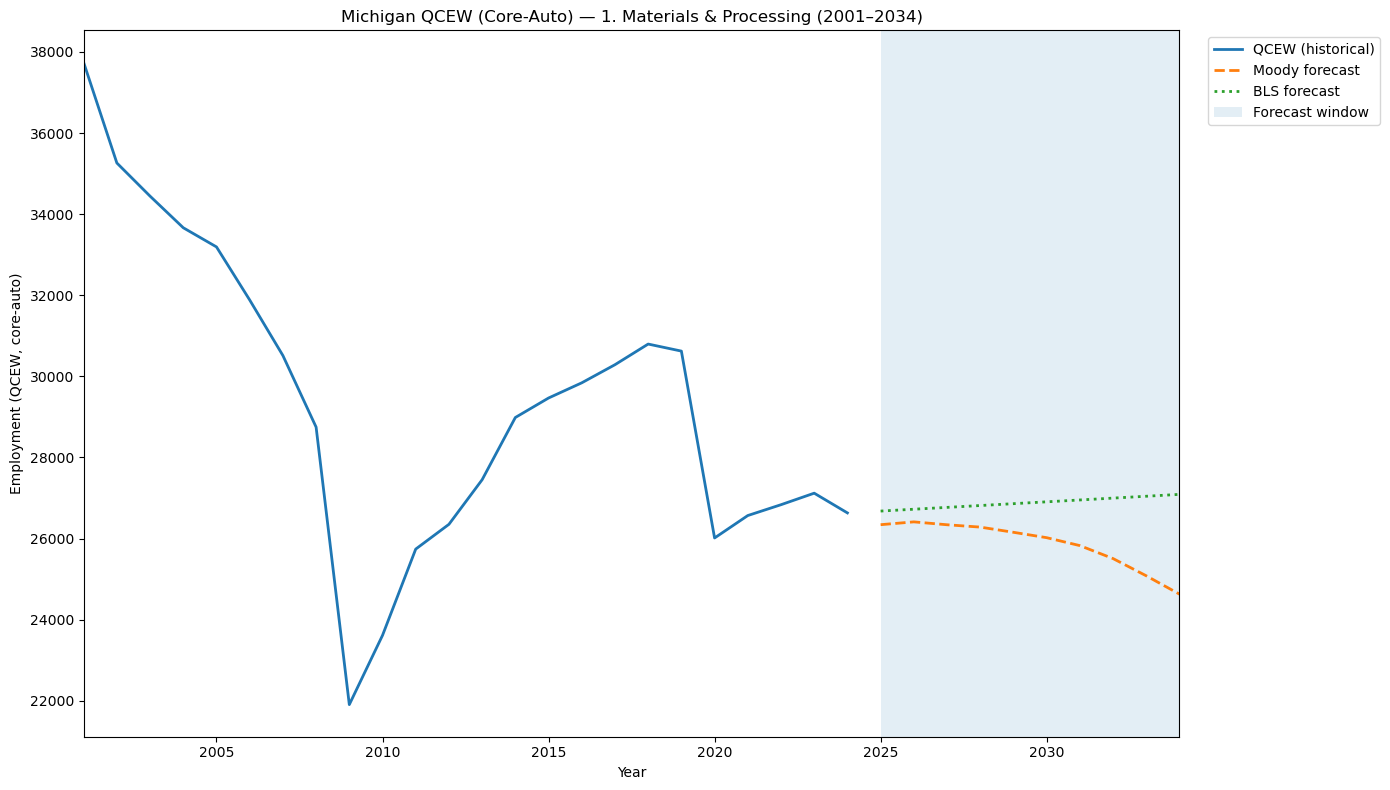

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_coreauto_segment_2_compare_2001_2034.png


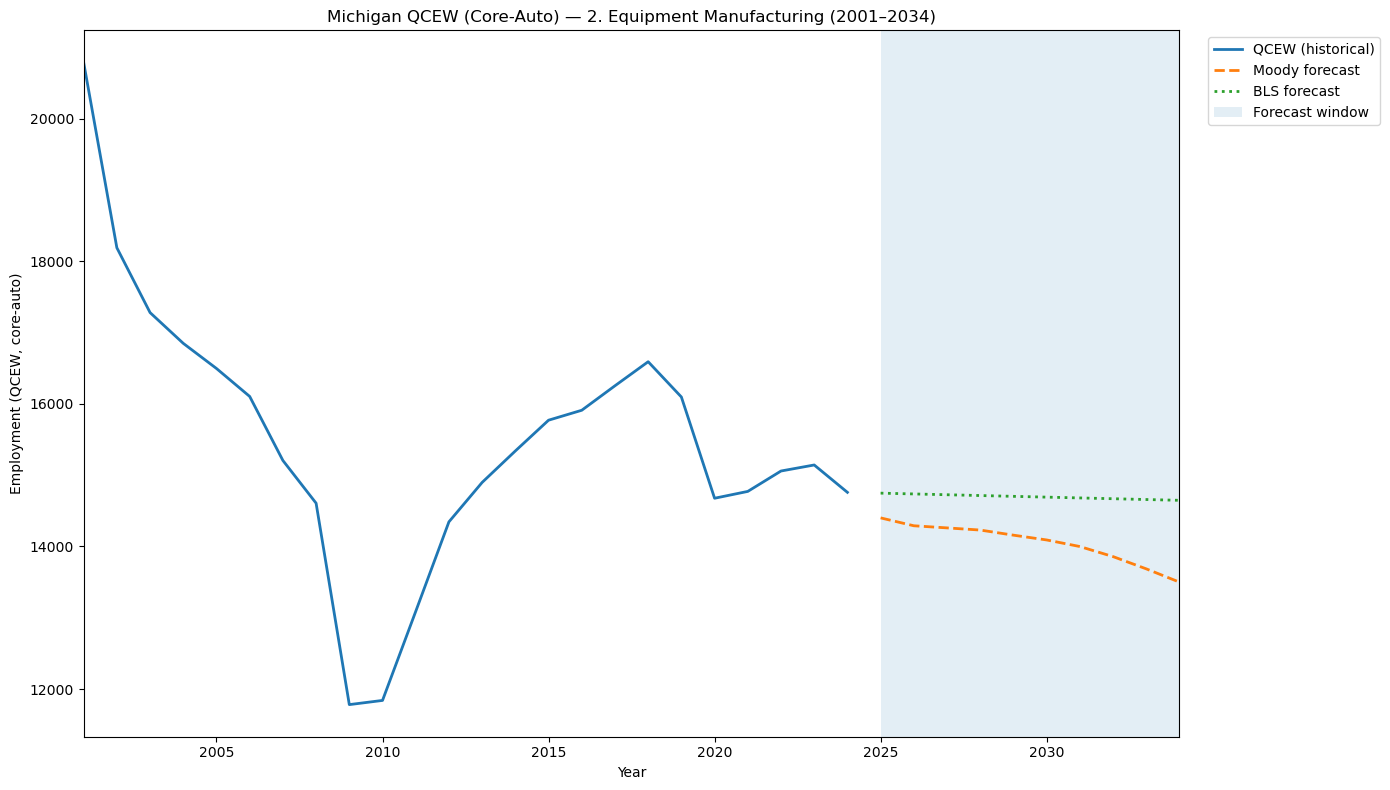

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_coreauto_segment_3_compare_2001_2034.png


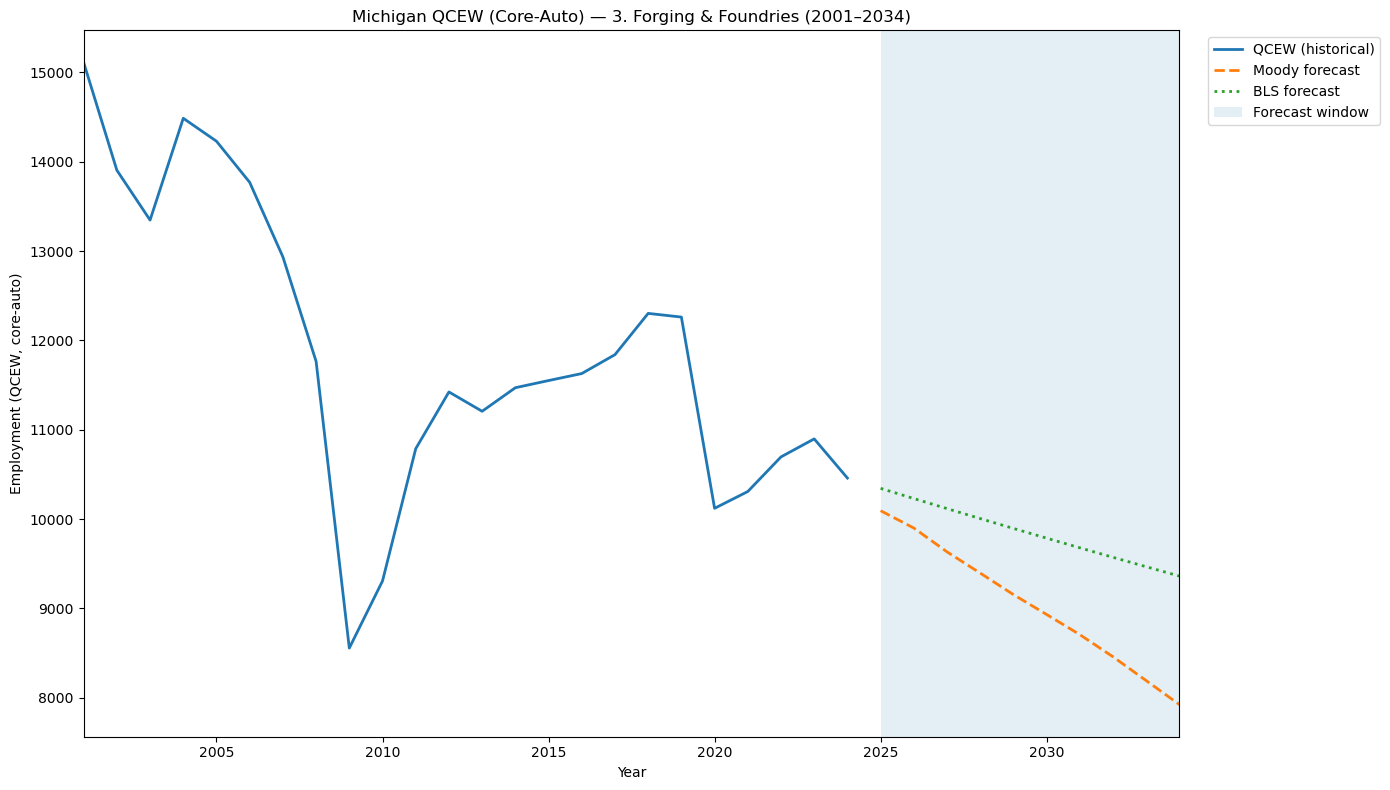

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_coreauto_segment_4_compare_2001_2034.png


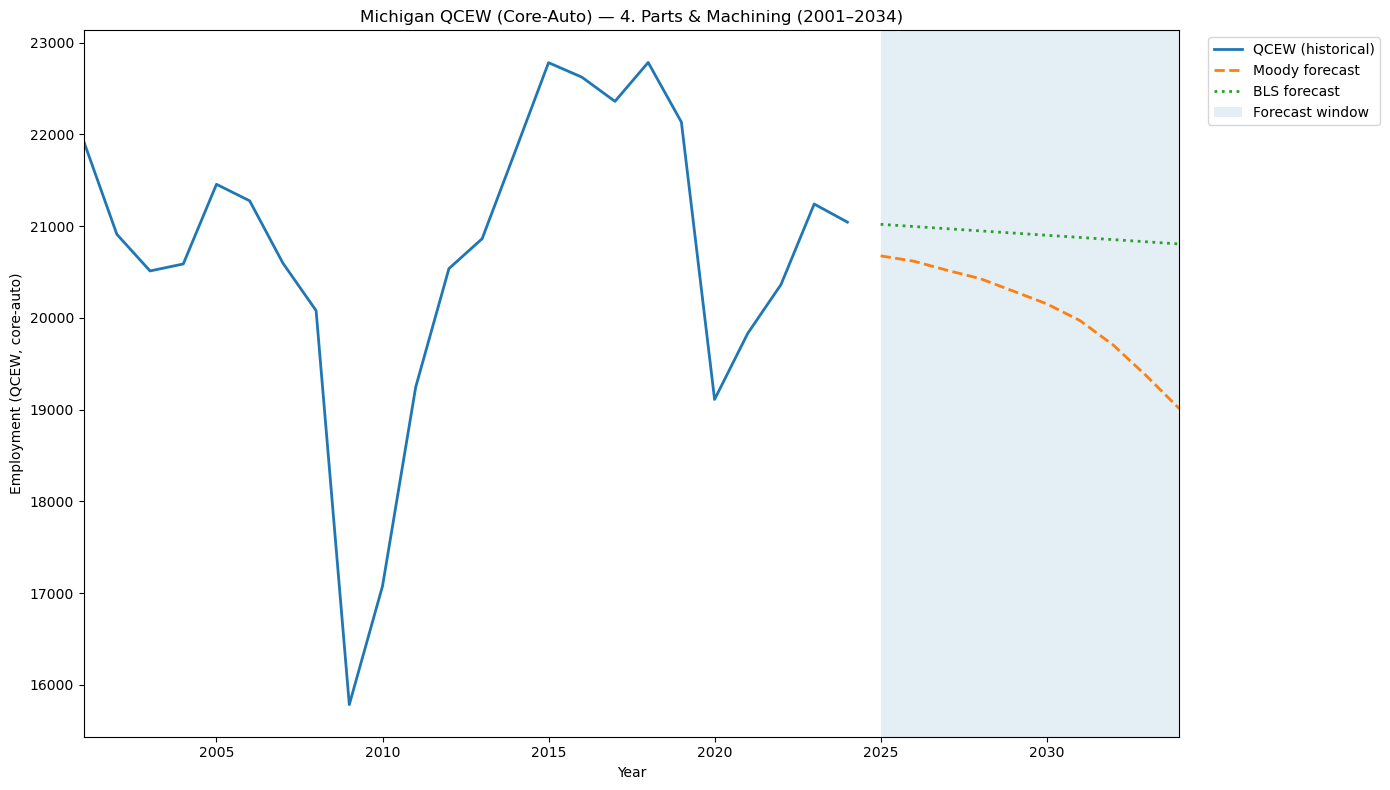

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_coreauto_segment_5_compare_2001_2034.png


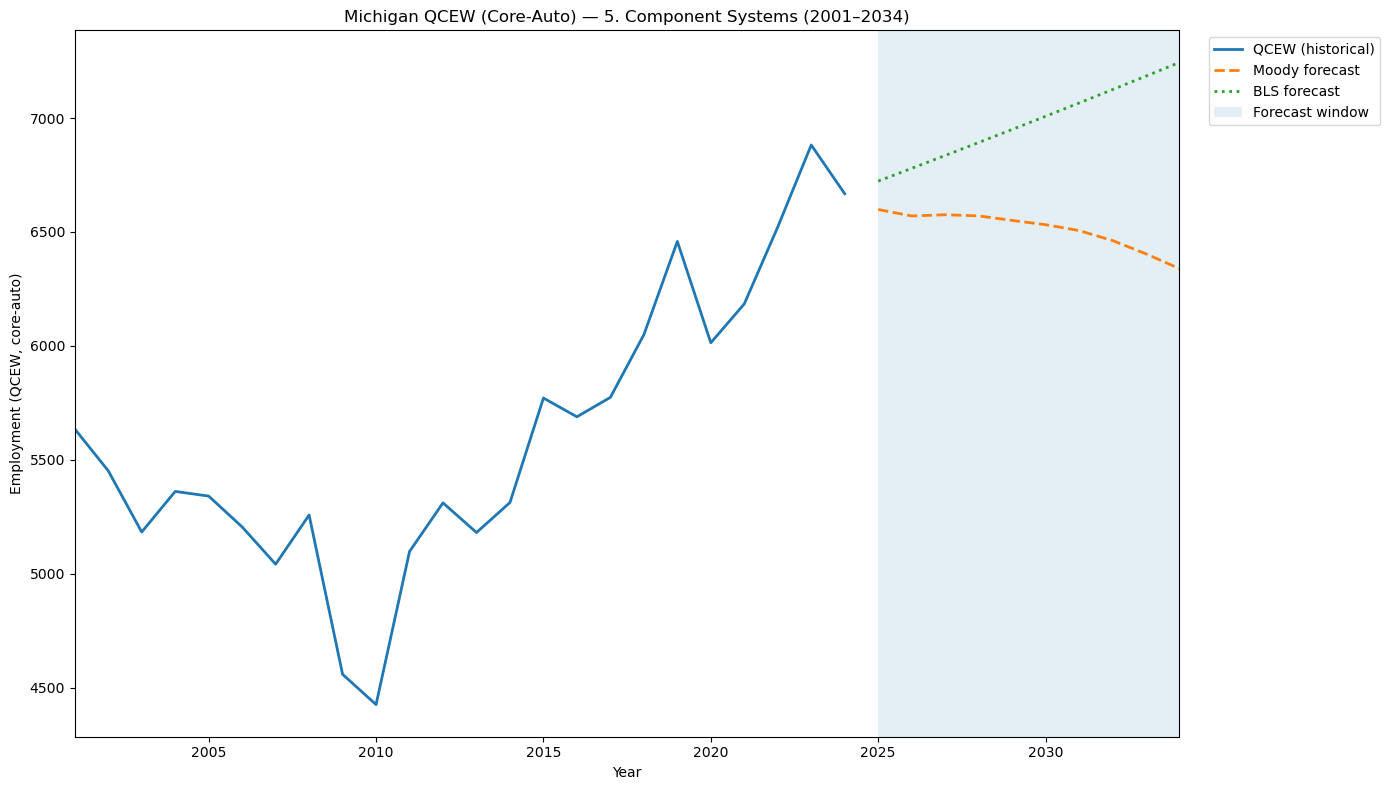

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_coreauto_segment_6_compare_2001_2034.png


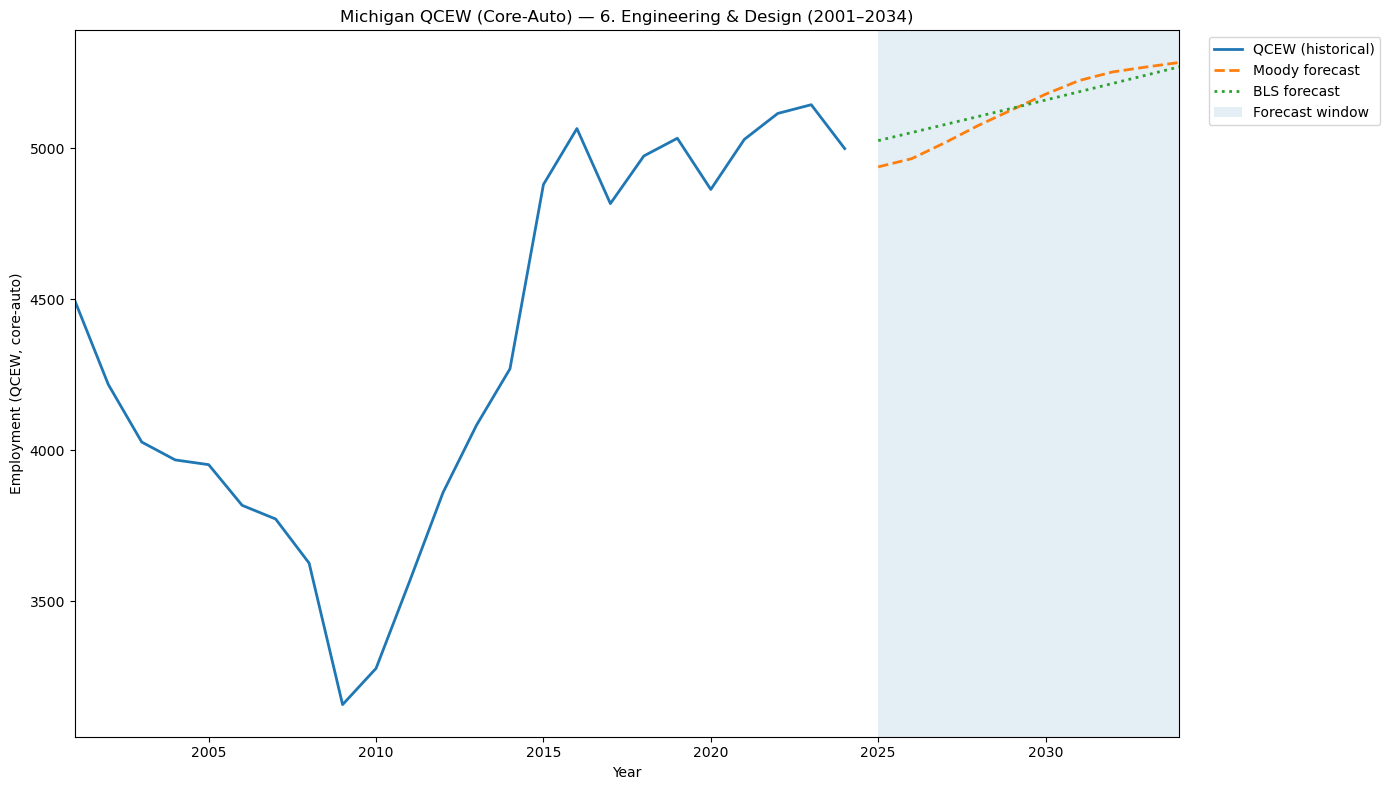

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_coreauto_segment_7_compare_2001_2034.png


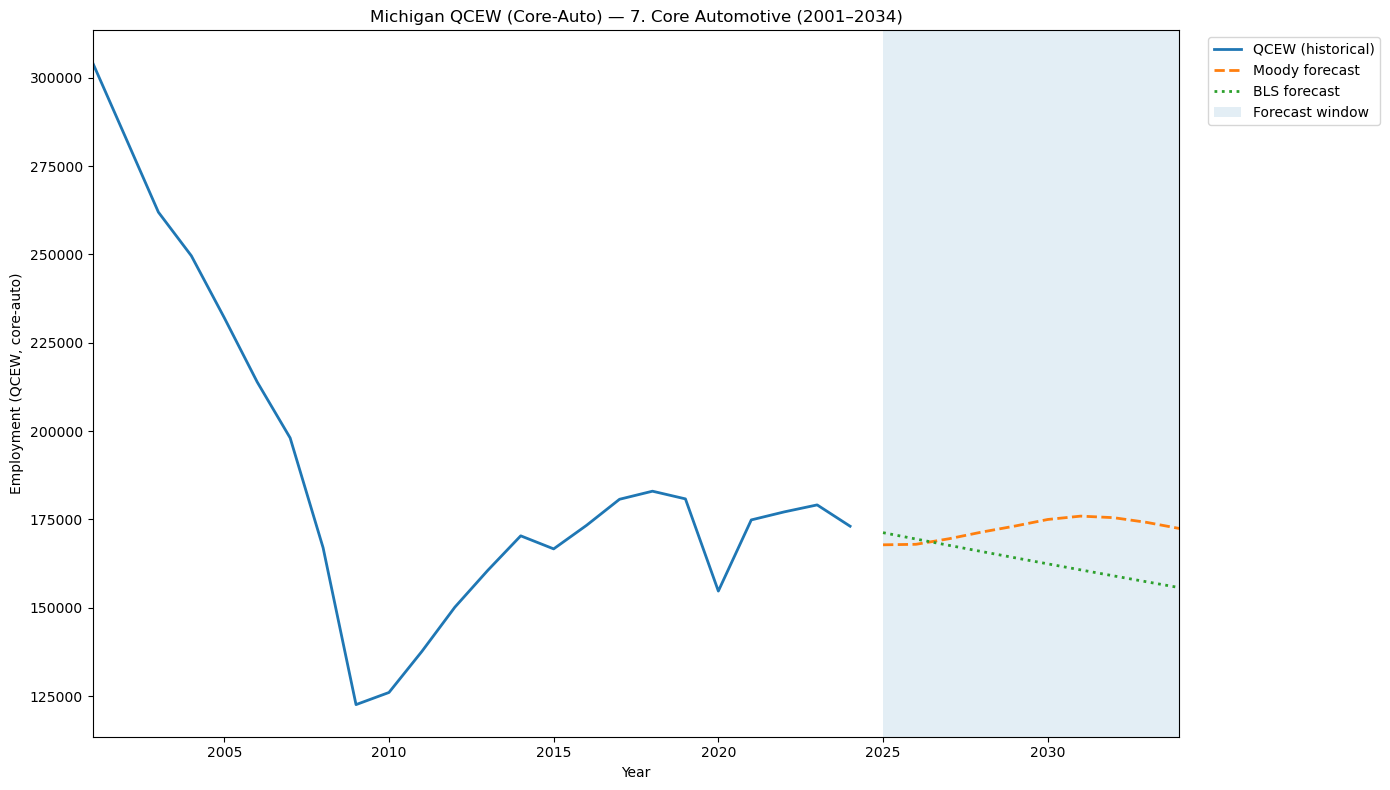

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_coreauto_segment_8_compare_2001_2034.png


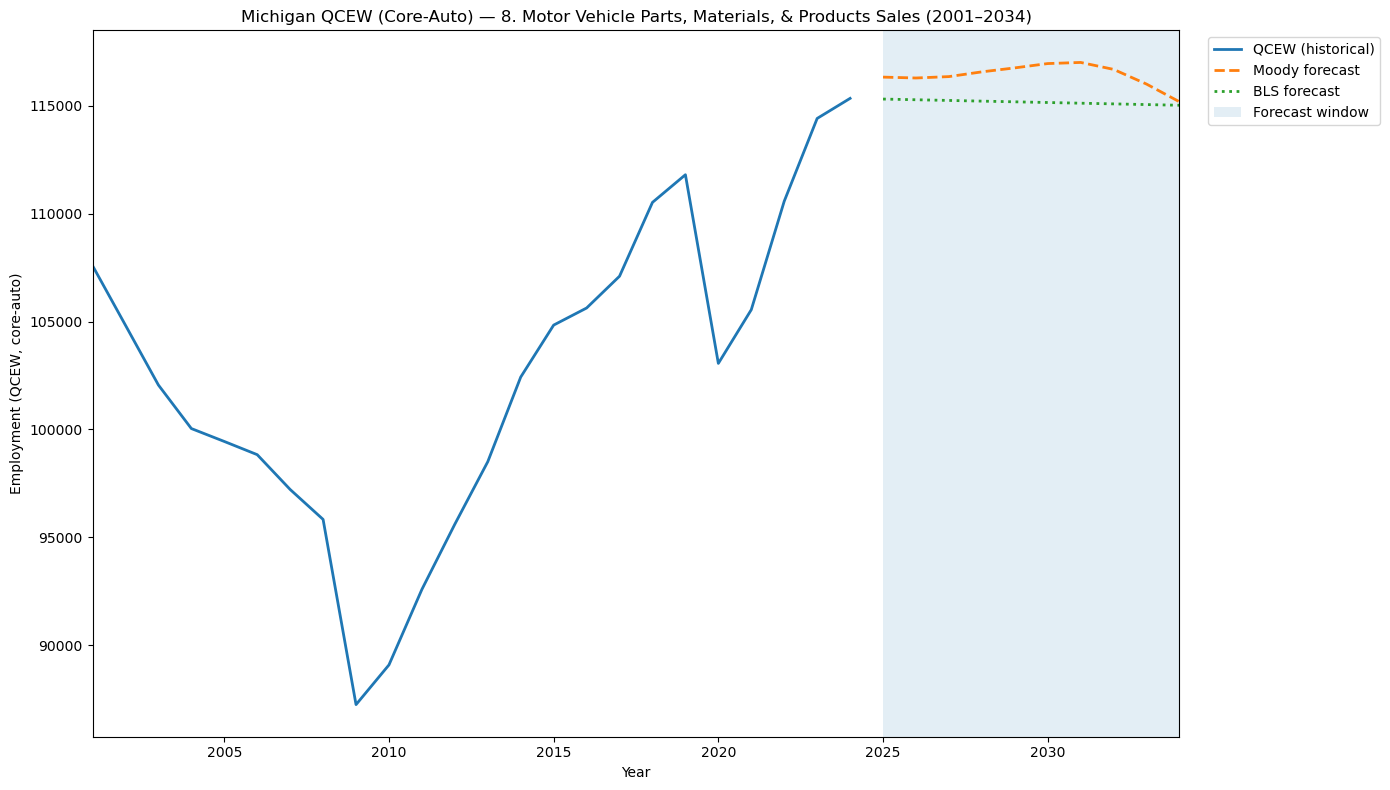

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_coreauto_segment_9_compare_2001_2034.png


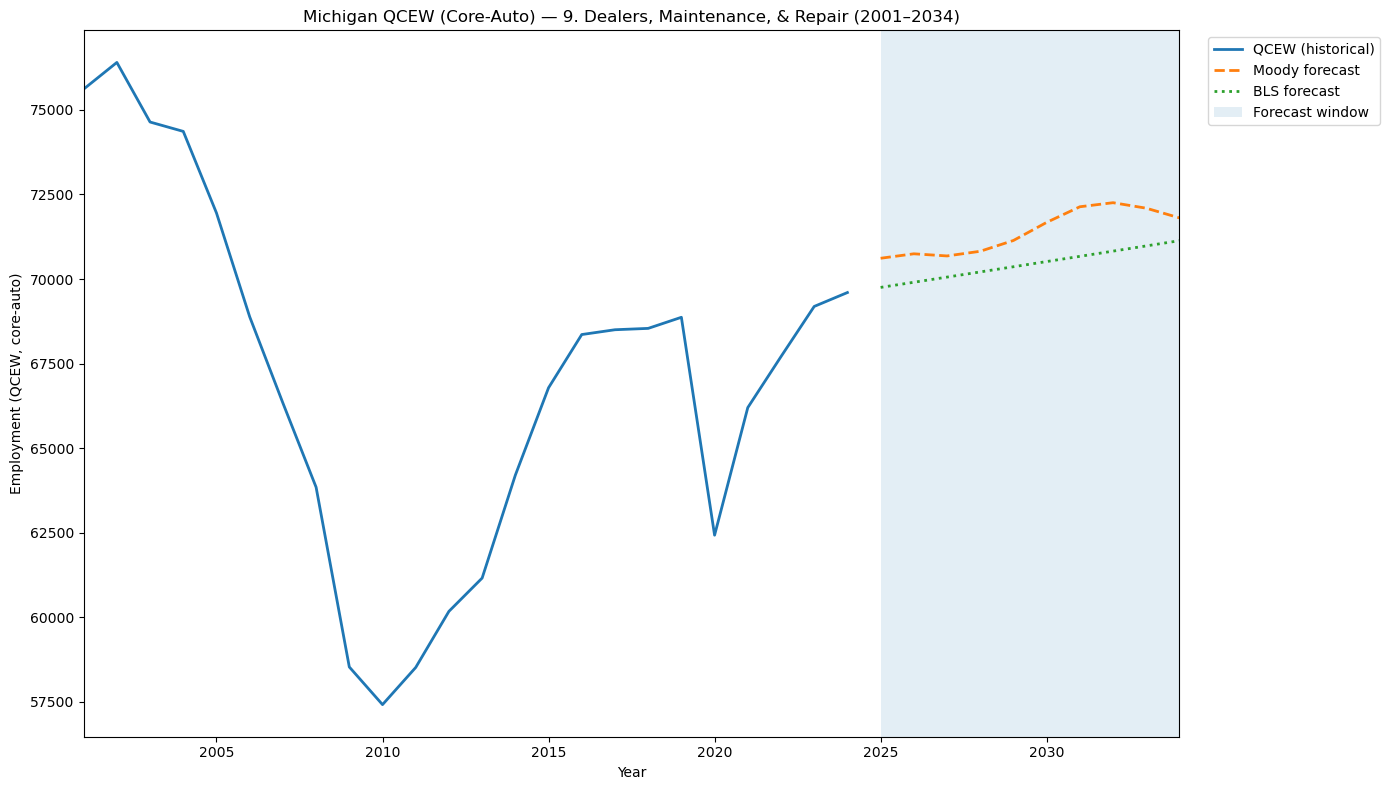

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_coreauto_segment_10_compare_2001_2034.png


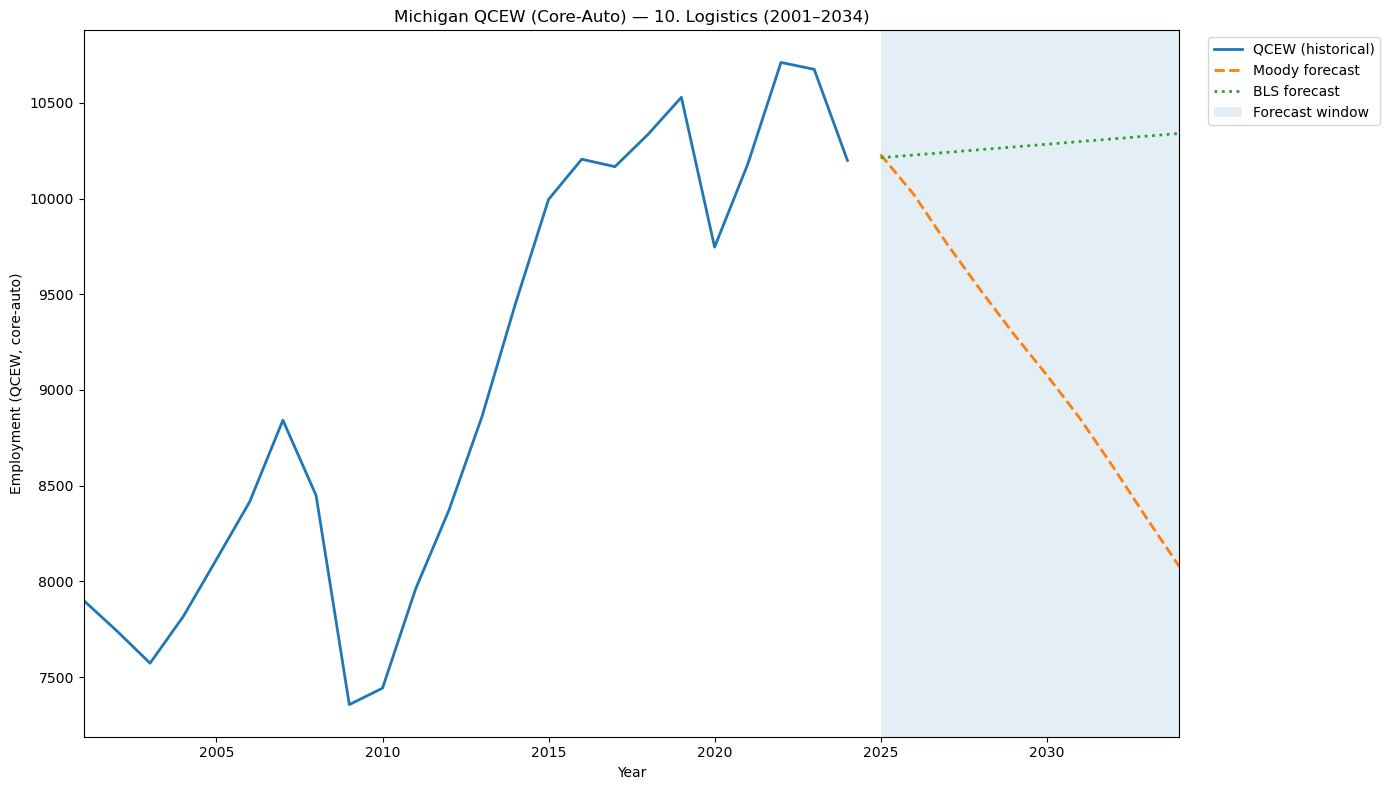

In [20]:

label_col = "segment_name" if "segment_name" in seg_base.columns else ("segment_label" if "segment_label" in seg_base.columns else None)
if label_col is None:
    raise KeyError("segment_name/segment_label not found in core-auto segment baseline file.")

for seg_id, g in seg_base.groupby("segment_id", sort=True):
    seg_label = g[label_col].dropna().iloc[0] if not g[label_col].dropna().empty else f"Segment {seg_id}"
    plot_segment_compare(int(seg_id), str(seg_label))



### Export an executed Markdown report (optional)
```bash
jupyter nbconvert --to markdown --execute notebooks/mi_qcew_coreauto_compare_forecasts.ipynb   --output mi_qcew_coreauto_compare_forecasts_executed.md   --output-dir reports/markdown   --ExecutePreprocessor.kernel_name=python3
```
